In [175]:
import cv2;
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
%matplotlib inline

# Estimating Essential Matrix

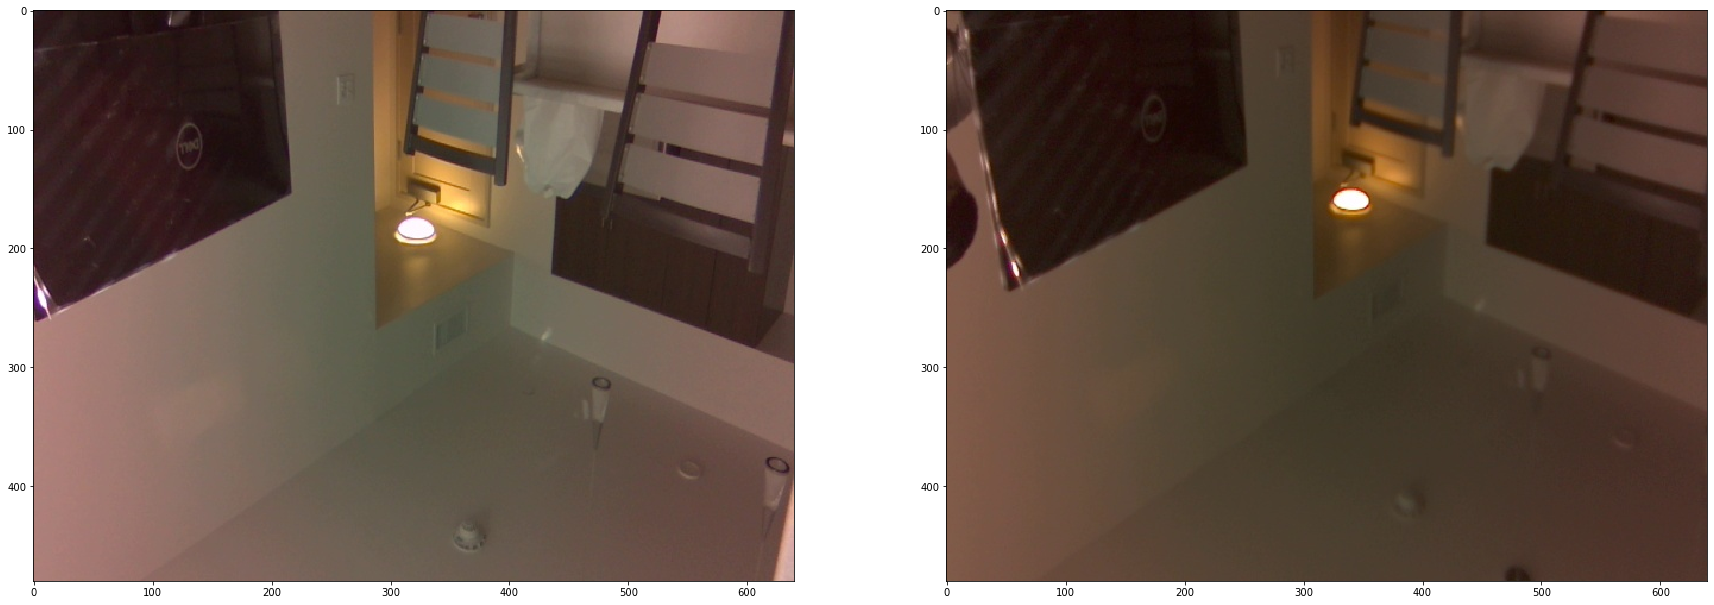

In [176]:
plt.figure(figsize=(30,30))
im1 = plt.imread('im1.jpg')
im2 = plt.imread('im2.jpg')
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

## ORB Testing

Testing the orb algorithm and visualizing it to see how well it gets keypoints.

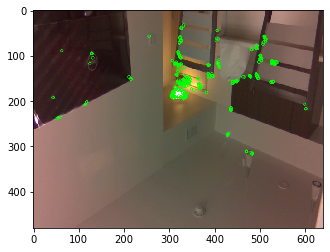

In [177]:
orb = cv2.ORB_create(nfeatures=100000, scoreType=cv2.ORB_FAST_SCORE)
kp = orb.detect(im1, None)
kp, des = orb.compute(im1, kp)

draw1 = cv2.drawKeypoints(im1, kp, None, color=(0,255,0), flags=0)
plt.imshow(draw1)
plt.show()

## Feature Matching + RANSAC

In [178]:
from skimage.measure import ransac
from skimage.transform import AffineTransform

In [209]:
def featureMatching1(im1,im2):
    
    '''
        Get orb features from both images
    '''
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    '''
        Setup a kd tree and perform Flann matching.
    '''
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    '''
        Parse out any of the bad matches
    '''
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    '''
        Implement ransac for outlier detection
    '''
    #ransac
    print(src_pts.shape, dst_pts.shape)
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=4, max_trials=40)
    
    
    
    '''
        Visualization code of the feature matching algorithm
    '''
    ## beginning of unnecessary
    n_inliers = np.sum(inliers)
    inlier_kp_left = [ cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers] ]
    inlier_kp_right = [ cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers] ]
    placehold_matches = [cv2.DMatch(idx,idx,1) for idx in range(n_inliers)]
    
    plt.figure(figsize=(15,15))
    final_img = cv2.drawMatches( im1, inlier_kp_left, im2, inlier_kp_right, placehold_matches, None )
    plt.imshow(final_img)
    plt.show()
    ## end of unnecessary
    
    
    return src_pts[inliers], dst_pts[inliers]

(22, 2) (22, 2)


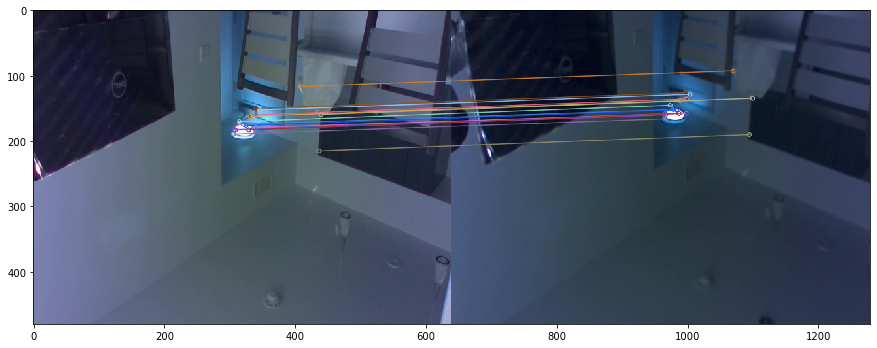

In [210]:
im1 = cv2.imread('im1.jpg')
im2 = cv2.imread('im2.jpg')

src_pts, dst_pts = featureMatching1(im1,im2)

In [211]:
src_pts

array([[340.80002, 150.     ],
       [331.2    , 162.     ],
       [307.2    , 182.40001],
       [339.84003, 159.84001],
       [309.31204, 183.16801],
       [315.18726, 170.03522],
       [440.43274, 159.25252],
       [320.99335, 174.18243],
       [306.06345, 189.11237],
       [406.09393, 116.45341],
       [346.37424, 152.28522],
       [325.47235, 176.1731 ],
       [340.40228, 179.15909],
       [329.65274, 182.74228],
       [437.1482 , 214.9909 ]], dtype=float32)

In [212]:
def featureMatching(im1,im2):
    '''
        Get orb features from both images
    '''
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    '''
        Setup a kd tree and perform Flann matching.
    '''
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    '''
        Implement ransac for outlier detection
    '''    
    #ransac
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=8, max_trials=40)
    
    
    return src_pts[inliers], dst_pts[inliers]

## 8-point algorithm

In [213]:
def eight_point(src_pts, dst_pts):
    assert src_pts.shape[0] == 2
    assert dst_pts.shape[0] == 2
    assert src_pts.shape[1] == dst_pts.shape[1]
    assert src_pts.shape[1] >= 8
    
    ones = np.ones(shape=src_pts.shape[1])
    
    #projective coords
    start = np.vstack((src_pts,ones))
    end = np.vstack((dst_pts,ones))
    
    end_x = start[0,:] * end
    end_y = start[1,:] * end
    end_1 = start[2,:] * end
    
    
    '''
        Using the x^T @ F @ x = 0 algorithm
        Formulate a least squares formulation.
        Solve using SVD
    '''
    A = np.vstack((end_x,end_y,end_1)).T # create homogenous matrix
    
    ATA = A.T@A
    
    U,S,V = np.linalg.svd(A)
    
    #e = V[:,np.argmin(S)]
    e = V[np.argmin(S),:]
    
    E = e.reshape(3,3)
    
    return E

In [243]:
stereo_data = cv2.FileStorage('stereo_cameras.xaml', cv2.FileStorage_READ)
K1 = stereo_data.getNode('K1').mat()
cam = cv2.VideoCapture('video.avi')

In [244]:

_, im1 = cam.read()
_, im2 = cam.read()
_, im3 = cam.read()
_, im4 = cam.read()
_, im5 = cam.read()
_, im6 = cam.read()
_, im7 = cam.read()
_, im8 = cam.read()
_, im9 = cam.read()
for i in range(10):
    cam.read()
_,im10 = cam.read()

In [245]:
h,w, _ = im1.shape
im1 = im1[:,:w//2]
im2 = im2[:,:w//2]
im3 = im3[:,:w//2]
im4 = im4[:,:w//2]
im5 = im5[:,:w//2]
im6 = im6[:,:w//2]
im7 = im7[:,:w//2]
im8 = im8[:,:w//2]
im9 = im9[:,:w//2]
im10 = im10[:,:w//2]

(58, 2) (58, 2)


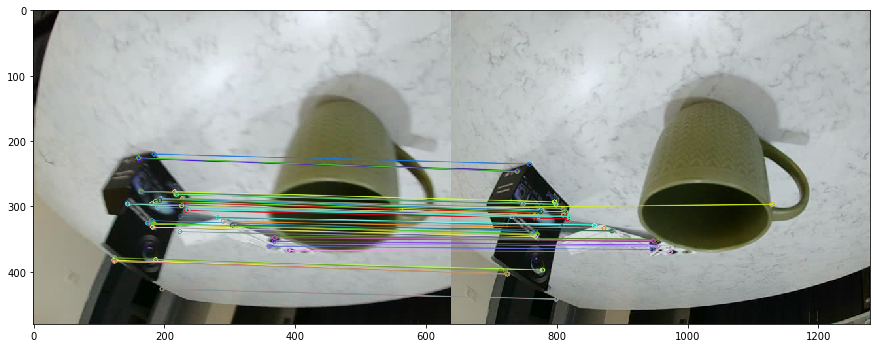

In [246]:
src_pts, dst_pts = featureMatching1(im1,im9)
E = eight_point(src_pts.T ,dst_pts.T)

### Decompose Essential Matrix using Cheirality Conditions

In [272]:
def triangulate(ptsL, ptsR, K, R, t):
    '''
        Assignment 2 code that will perform triangulation 
        by performing optimization on the z coords of the two cameras.
    '''
    qL = ptsL.copy()
    qR = ptsR.copy()
    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]
    c = np.array([[cx,cy]]).T
    
    #setup the equations.
    qL = qL - c
    qL[0,:] = qL[0,:] / fx
    qL[1,:] = qL[1,:] / fy
    
    qR = qR - c
    qR[0,:] = qR[0,:] / fx
    qR[1,:] = qR[1,:] / fy
    
    qL = np.vstack( (qL,np.ones(qL.shape[1])) )
    qR = np.vstack( (qR,np.ones(qR.shape[1])) )
    
    Rlql = qL
    Rrqr = (R @ qR) * -1
    b = t    
    
    #formulate optimization problem
    zhatL = np.zeros(shape=(1,ptsL.shape[1]))
    zhatR = np.zeros(shape=(1,ptsR.shape[1]))
    for i in range(ptsL.shape[1]):
        R_lidx = Rlql[:,i].reshape(3,1)
        R_ridx = Rrqr[:,i].reshape(3,1)
        A = np.hstack((R_lidx,R_ridx))
        
        zhat = np.linalg.lstsq(A,b)[0]
        zhatL[:,i] = zhat[0]
        zhatR[:,i] = zhat[1]
    #afterwards, use the solution to solve for the points.
    PL = zhatL * qL
    PR = zhatR * qR
    
    P1 = PL
    P2 = R @ PR + t
    pts3 = (P1+P2)/2
    return pts3

In [273]:
def decomposeE(F, src_pts, dst_pts, K):
    # go from fundamental to essential matrix
    E = K.T @ F @ K # fundamental
    
    #clean up noise from the essential matrix
    U,S,VT = np.linalg.svd(E)
    s = (S[0] + S[1])/2
    S = np.array([[s,0,0], [0,s,0], [0,0,0]])
    E = U @ S @ VT
    
    # find the 4 estimations of the essential matrix
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    U,S,VT = np.linalg.svd(E)
    
    R1 = U @ W @ VT
    R2 = U @ W.T @ VT
    R3 = U @ W @ VT
    R4 = U @ W.T @ VT
    
    C1 = U[:,2].reshape(3,1)
    C2 = -U[:,2].reshape(3,1)
    C3 = U[:,2].reshape(3,1)
    C4 = U[:,2].reshape(3,1)
    
    #check rotation determinants
    # this uses the Cheirality Conditions 
    if np.linalg.det(R1) < 0:
        R1 = -R1
        C1 = -C1
    if np.linalg.det(R2) < 0:
        R2 = -R2
        C2 = -C2
    if np.linalg.det(R3) < 0:
        R3 = -R3
        C3 = -C3
    if np.linalg.det(R4) < 0:
        R4 = -R4
        C4 = -C4
    pts3_1 = triangulate(src_pts, dst_pts, K, R1.T, -R1.T@C1)
    pts3_2 = triangulate(src_pts, dst_pts, K, R2.T, -R2.T@C2)
    pts3_3 = triangulate(src_pts, dst_pts, K, R3.T, -R3.T@C3)
    pts3_4 = triangulate(src_pts, dst_pts, K, R4.T, -R4.T@C4)
    
    z_1 = R1[2,:]@(pts3_1 - C1)
    z_2 = R2[2,:]@(pts3_2 - C2)
    z_3 = R3[2,:]@(pts3_3 - C3)
    z_4 = R4[2,:]@(pts3_4 - C4)
    
    s1 = (z_1 > 0).sum()
    s2 = (z_2 > 0).sum()
    s3 = (z_3 > 0).sum()
    s4 = (z_4 > 0).sum()
    
    max_sum = max([s1,s2,s3,s4])
    if max_sum == s1:
        return R1.T, -R1.T@C1
    elif max_sum==s2:
        print(pts3_2[2,:])
        return R2.T, -R2.T@C2
    elif max_sum==s3:
        return R3.T, -R3.T@C3
    else:
        return R4.T, -R4.T@C4

In [274]:
R,t = decomposeE(E, src_pts.T, dst_pts.T, K1)

2 55 2 0
55
[0.57543724 0.94035291 0.37308654 0.57560671 0.47153443 0.48202512
 0.650895   0.64357882 0.57166817 0.32801456 0.43010015 0.71760792
 0.64304902 0.34294537 0.56707312 0.32846521 0.3340383  0.106669
 0.6444831  0.42389713 0.54278017 0.74600486 0.55874961 0.69919186
 0.36109233 0.33428544 0.51347257 0.36897667 0.34060036 0.51918819
 0.73767654 0.80186578 0.56999522 0.32084784 0.28823441 0.51317672
 0.29740624 0.57268185 0.65048074 0.52691659 0.42322783 0.53554232
 0.51346685 0.35826113 0.48186586 0.7862343  0.09918607 0.16408151
 0.31645044 0.51874027 0.339932   0.57259348 0.29636497 0.47960869
 0.13217567]


/tmp/ipykernel_292996/2296916679.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  zhat = np.linalg.lstsq(A,b)[0]


## Pose Visualization

[[-1.38777878e-16]]
[[1.11022302e-16]]
[[1.94289029e-16]]


/tmp/ipykernel_292996/2296916679.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  zhat = np.linalg.lstsq(A,b)[0]


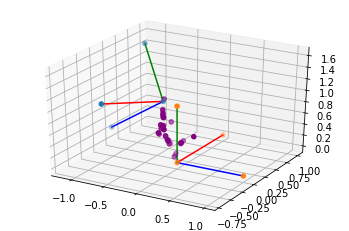

In [275]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
transform = np.hstack((R,t))
x = np.array([[1,0,0,1]]).T
y = np.array([[0,1,0,1]]).T
z = np.array([[0,0,1,1]]).T
ze = np.array([[0,0,0,1]]).T

xt = transform @ x
yt = transform @ y
zt = transform @ z
zet = transform @ ze
pts = np.hstack((xt,yt,zt,zet))

vecA = xt - zet
vecB = yt - zet
vecC = zt - zet
print(vecA.T @ vecB)
print(vecA.T @ vecC)
print(vecB.T @ vecC)
assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'

ax.scatter(pts[0,:], pts[1,:], pts[2,:])

xvec = np.hstack((zet,xt))
yvec = np.hstack((zet,yt))
zvec = np.hstack((zet,zt))
ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

xvec = np.hstack((ze,x))
yvec = np.hstack((ze,y))
zvec = np.hstack((ze,z))
pts = np.hstack((x,y,z,ze))
ax.scatter(pts[0,:], pts[1,:], pts[2,:])


pts3 = triangulate(src_pts.T, dst_pts.T, K1, R, t)

ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

ax.scatter(pts3[0,:], pts3[1,:], pts3[2,:], color='purple')

plt.show()

In [276]:
def visual(R,t,ax):
    x = np.array([[1,0,0,1]]).T
    y = np.array([[0,1,0,1]]).T
    z = np.array([[0,0,1,1]]).T
    ze = np.array([[0,0,0,1]]).T
    
    transform = np.hstack((R,t))
    
    xt = transform @ x
    yt = transform @ y
    zt = transform @ z
    zet = transform @ ze
    
    vecA = xt - zet
    vecB = yt - zet
    vecC = zt - zet
    print(vecA.T @ vecB)
    print(vecA.T @ vecC)
    print(vecB.T @ vecC)
    assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
    assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
    assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'
    
    pts = np.hstack((xt,yt,zt,zet))
    ax.scatter(pts[0,:], pts[1,:], pts[2,:])
    xvec = np.hstack((zet,xt))
    yvec = np.hstack((zet,yt))
    zvec = np.hstack((zet,zt))
    ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
    ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
    ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

In [277]:
def getAttitude(rot):
    yaw = np.arctan2(rot[1,0], rot[0,0])
    pitch = np.arctan2(-rot[2,0], np.sqrt(rot[2,1]**2 + rot[2,2]**2))
    roll = np.arctan2(rot[2,1], rot[2,2])
    return pitch,roll,yaw

In [278]:
getAttitude(R)

(0.6618476574634168, 0.4391781221724716, -3.0985511041312326)